# Evaluating

The early Bluesky feed is deterministic–how can we take advantage of this, and our understanding of the Bluesky app usage patterns, to reconstruct the posts each user saw?

Questions:

- What's the upper bound on the number of posts that we can reconstruct for each user? Ignoring when a user saw a post
  - What percentage of a given user's post interactions can be captured by their known Bluesky usage patterns (chronological "Following" feed, threads/replies, profile views, etc)?
  -


In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import typing as t
import pandas as pd

from utils import records, Post, did_from_uri


In [2]:
# Constants

RAW_STREAM_DIR = "../data/stream-2023-07-01"

In [74]:
# === Prediction Tracking ===

# What posts do we predict that each user has seen?
predicted_seen: dict[str, list[tuple[str, str]]] = {}

# What posts do we know that each user has seen based on their interactions?
true_seen: dict[str, list[tuple[str, str]]] = {}

# === Network Information Management ===


class UserInfo(t.TypedDict):
    posts: set[str]
    followers: set[str]


user_info: dict[str, UserInfo] = {}  # Relevant information about each user


class PostInfo(t.TypedDict):
    parent_uri: str | None  # Allows thread reconstruction on-the-fly
    subject_uri: str | None


post_info: dict[str, PostInfo] = {}  # Relevant information about each root post
deleted_posts = set[str]()

# === Helper functions ===


def gather_thread(uri: str) -> list[str]:
    """Gather the URIs of all posts in a thread from a single reply to its root."""
    post = post_info[uri]  # Info about current post
    uris: list[str] = []

    while True:
        # Found root
        if post["parent_uri"] is None:
            return uris

        # Broken thread (TODO: Could also return root here?)
        if post["parent_uri"] not in post_info:
            deleted_posts.add(post["parent_uri"])
            return uris

        uris.append(post["parent_uri"])
        post = post_info[post["parent_uri"]]


def get_quoted_uri(post: Post) -> t.Optional[str]:
    if "embed" not in post or not post["embed"]:
        return None

    try:
        if post["embed"]["$type"] == "app.bsky.embed.record":
            return post["embed"]["record"]["uri"]
        elif post["embed"]["$type"] == "app.bsky.embed.recordWithMedia":
            return post["embed"]["record"]["record"]["uri"]
    except KeyError:
        return None


# === Firehose Iteration ===

END_DATE = "2023-04-01"

# Iterate through each historical record in Bluesky's firehose
for record in records(RAW_STREAM_DIR, end_date=END_DATE, log=True):
    # New profile identified
    if record["did"] not in user_info:
        user_info[record["did"]] = {"followers": set(), "posts": set()}
        predicted_seen[record["did"]] = []
        true_seen[record["did"]] = []

    match record["$type"]:
        case "app.bsky.feed.post":
            # Keep track of all of a user's posts
            user_info[record["did"]]["posts"].add(record["uri"])

            # A user's post will be served to all of their followers as of the time of that post
            for follower in user_info[record["did"]]["followers"]:
                predicted_seen[follower].append((record["uri"], "chronological-post"))

            # Keep track of all posts
            post_info[record["uri"]] = {
                "parent_uri": None,
                "subject_uri": None,
            }

            # If a user replied to a post, we know that user saw all parent posts in that thread
            if "reply" in record and record["reply"]:
                root_uri = record["reply"]["root"]["uri"]
                parent_uri = record["reply"]["parent"]["uri"]

                # If root of thread not already tracked, mark as deleted
                if root_uri not in post_info:
                    deleted_posts.add(root_uri)

                # Update post info with reply information
                post_info[record["uri"]]["parent_uri"] = parent_uri

                # Gather all parent URIs in the thread, including the root
                parent_uris = gather_thread(record["uri"])

                # A user will see all previous replies in their thread chain
                predicted_seen[record["did"]].extend(
                    [(uri, "thread-post") for uri in parent_uris]
                )
                true_seen[record["did"]].extend(
                    [(uri, "thread-post") for uri in parent_uris]
                )

                # All creators of parent posts will see this reply post
                for uri in parent_uris:
                    did = did_from_uri(uri)
                    predicted_seen[did].append((record["uri"], "replied-to"))
                    true_seen[did].append((record["uri"], "replied-to"))

            # TODO: The other people within that thread also probably saw that reply/quote

            # If a user quoted a post, we know they saw the subject post
            quoted_uri = get_quoted_uri(record)
            if quoted_uri:
                predicted_seen[record["did"]].append((quoted_uri, "quote-post"))

                # Creator of the quoted post will see this quote post
                quoted_did = did_from_uri(quoted_uri)
                predicted_seen[quoted_did].append((record["uri"], "quoted-to"))

        case "app.bsky.graph.follow":
            if record["subject"] not in user_info:  # Check if previously unseen user
                user_info[record["subject"]] = {"followers": set(), "posts": set()}
                predicted_seen[record["subject"]] = []
                true_seen[record["subject"]] = []

            # Keep track of all of a user's followers
            user_info[record["subject"]]["followers"].add(record["did"])

            # When a user follows another user, they see all of that user's previous posts
            predicted_seen[record["did"]].extend(
                [
                    (uid, "backfill-post")
                    for uid in user_info[record["subject"]]["posts"]
                ]
            )

        case "app.bsky.feed.like":
            subject_uri = record["subject"]["uri"]

            # If a user liked a post, we know they saw it
            true_seen[record["did"]].append((subject_uri, "like"))

            # Log if that post no longer exists
            if subject_uri not in post_info:
                deleted_posts.add(subject_uri)

        case "app.bsky.feed.repost":
            subject_uri = record["subject"]["uri"]

            # If a user reposted a post, we know they saw it
            true_seen[record["did"]].append((record["subject"]["uri"], "repost"))

            # Log if that post no longer exists
            if subject_uri not in post_info:
                deleted_posts.add(subject_uri)

            # A user's repost will be served to all of their followers at the time of that post
            for follower in user_info[record["did"]]["followers"]:
                predicted_seen[follower].append((record["subject"]["uri"], "repost"))

        case _:
            continue

136/136 (100.00%) - 0.0m until done

In [84]:
# Verify the coverage of the feed for each user

MIN_INTERACTIONS = 5

n_interactive = 0
precisions = []
recalls = []
dids = []
n_interactions = []
n_true_seen = []

for did, seen in true_seen.items():
    # Filter out any interactions with deleted posts
    # seen_exists = [item for item in seen if item[0] not in deleted_posts]
    seen_exists = seen

    # If user hasn't interacted with enough posts, ignore for analysis
    if len(seen_exists) < MIN_INTERACTIONS:
        continue

    n_interactive += 1
    n_interactions.append(len(seen_exists))
    dids.append(did)

    true_uris = set([uri for uri, _ in seen_exists])
    pred_uris = set([uri for uri, _ in predicted_seen[did]])
    n_true_seen.append(len(true_uris))

    correct_preds = true_uris.intersection(pred_uris)

    precision = len(correct_preds) / len(pred_uris) if len(pred_uris) > 0 else 0
    recall = len(correct_preds) / len(true_uris) if len(true_uris) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)

print("\n=== AGGREGATED FEED STATS ===")

mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

var_precision = np.var(precisions)
var_recall = np.var(recalls)

# Calculate median precision and recall
median_precision = np.median(precisions)
median_recall = np.median(recalls)

print(
    f"- # interactive users: {n_interactive}/{len(true_seen)} "
    f"({n_interactive / len(true_seen):.4f}%)"
)

# Mean percentage of a user's reconstructed feed that was interacted with by them
print(
    f"- Mean Precision: {mean_precision:.4f} (variance: {var_precision:.4f}), Median: {median_precision:.4f}"
)

# Mean percentage of a user's interactions that are included within their reconstructed feed
print(
    f"- Mean Recall: {mean_recall:.4f} (variance: {var_recall:.4f}), Median: {median_recall:.4f}"
)

# Number of posts deleted from the network (estimated)
print(
    f"- Deleted posts: {len(deleted_posts)}/{len(post_info)} ({len(deleted_posts) / len(post_info) * 100:.4f}%)"
)

"""=== AGGREGATED FEED STATS ===
- # interactive users: 2239/5964 (0.3754%)
- Mean Precision: 0.0515 (variance: 0.0257), Median: 0.0060
- Mean Recall: 0.8008 (variance: 0.0470), Median: 0.8571
- Deleted posts: 16641/109862 (15.1472%)"""



=== AGGREGATED FEED STATS ===
- # interactive users: 2239/5964 (0.3754%)
- Mean Precision: 0.0515 (variance: 0.0257), Median: 0.0060
- Mean Recall: 0.8008 (variance: 0.0470), Median: 0.8571
- Deleted posts: 16641/109862 (15.1472%)


'=== AGGREGATED FEED STATS ===\n- # interactive users: 2239/5964 (0.3754%)\n- Mean Precision: 0.0515 (variance: 0.0257), Median: 0.0060\n- Mean Recall: 0.8008 (variance: 0.0470), Median: 0.8571\n- Deleted posts: 16641/109862 (15.1472%)'

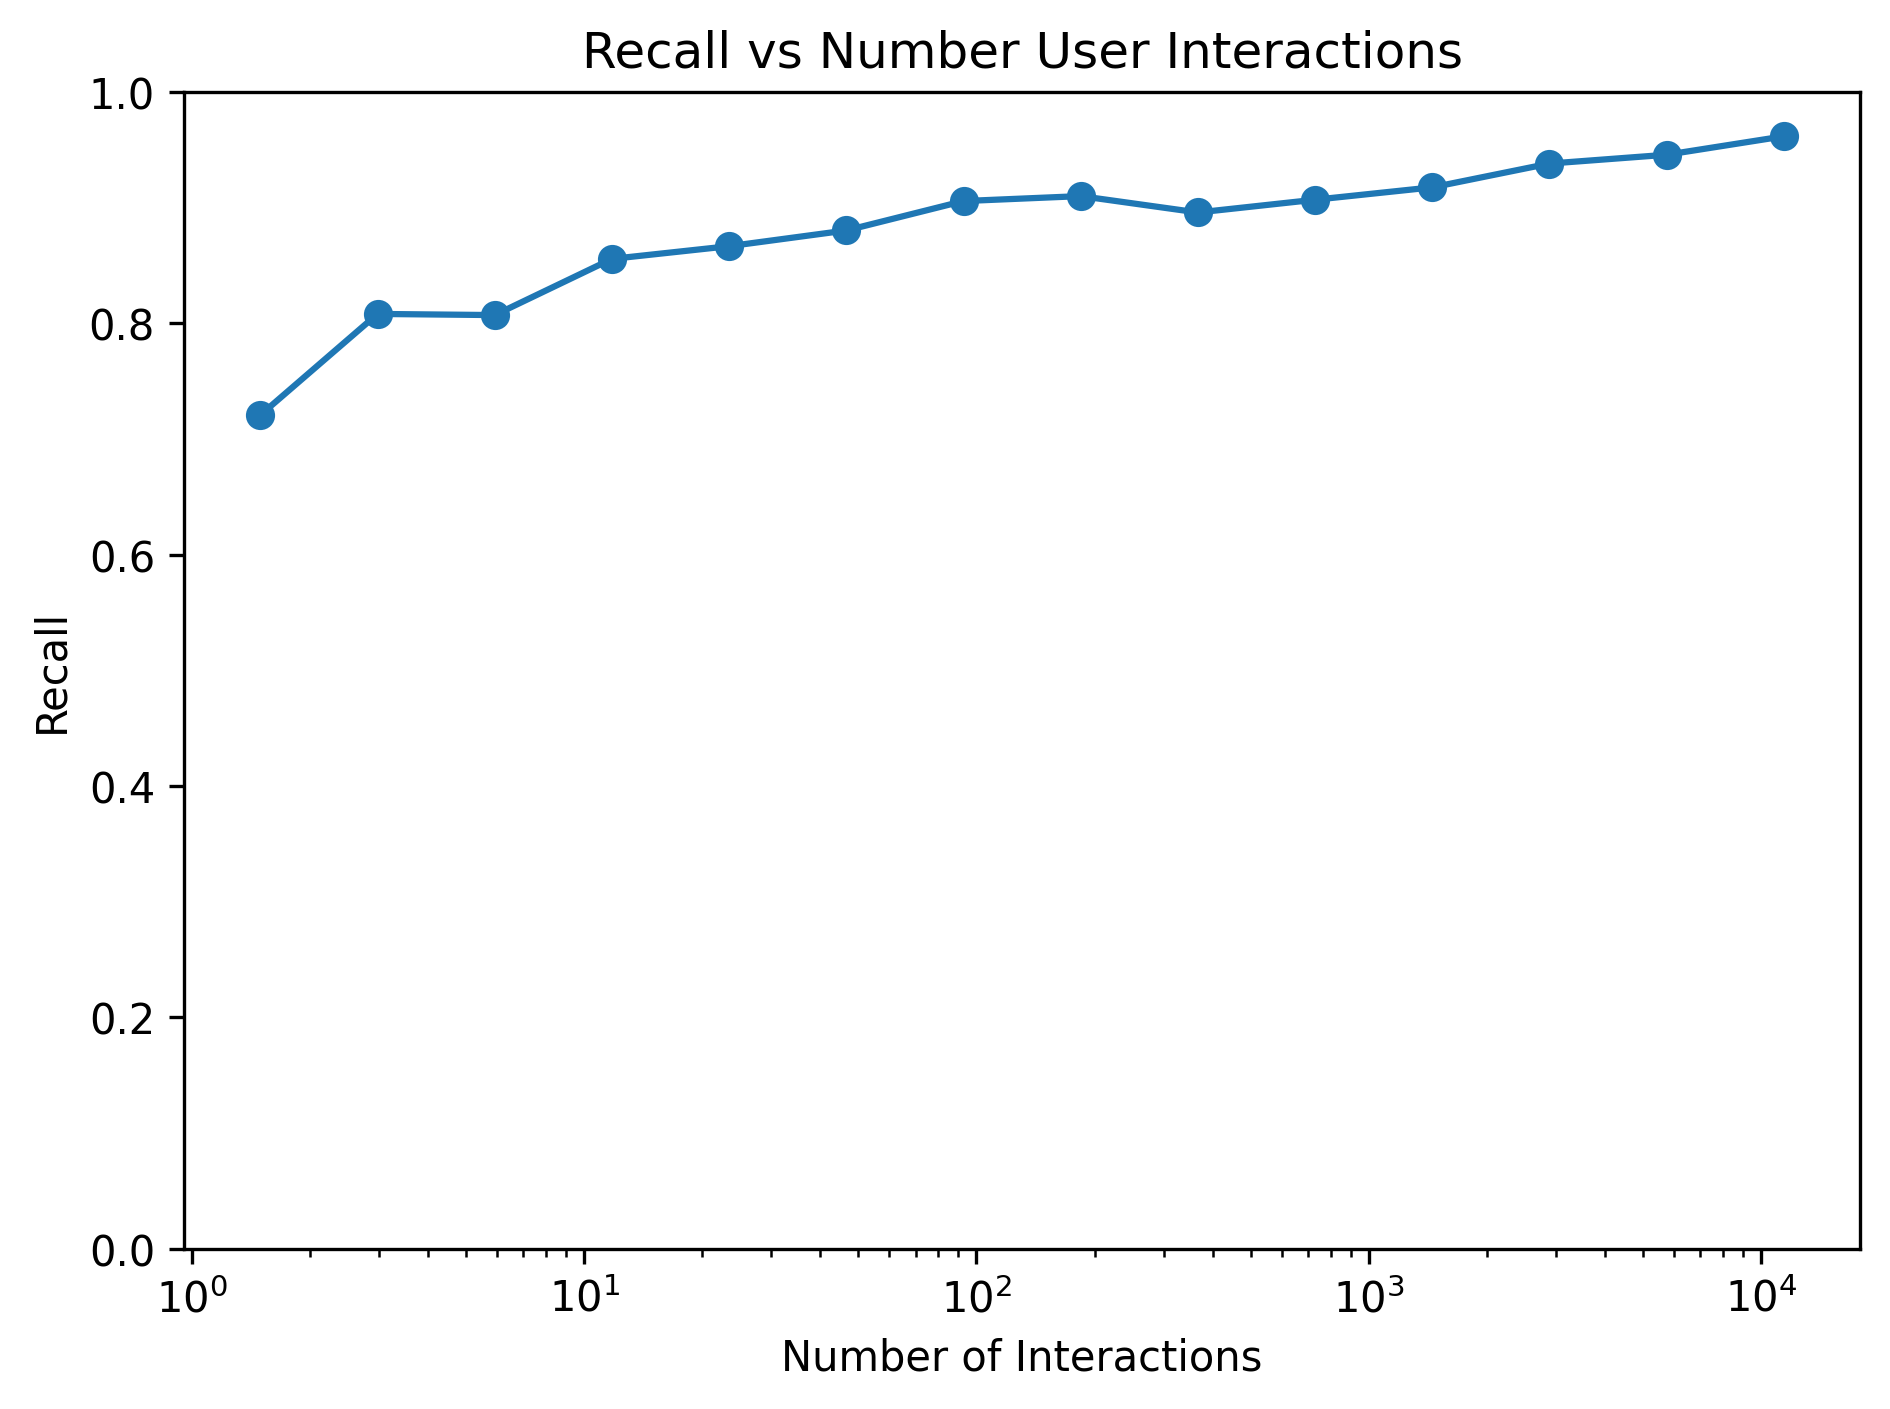

In [76]:
# Visualize recall with interactions

df = pd.DataFrame(
    {
        "dids": dids,
        "precision": precisions,
        "recall": recalls,
        "n_true_seen": n_true_seen,
        "n_interactions": n_interactions,
    }
)

# Create logarithmic bins
bins = np.logspace(
    np.log10(df["n_interactions"].min()), np.log10(df["n_interactions"].max()), 15
)
bin_indices = np.digitize(df["n_interactions"], bins)

# Calculate mean recall for each bin
bin_means = [df["recall"][bin_indices == i].mean() for i in range(1, len(bins))]
bin_counts = [len(df["recall"][bin_indices == i]) for i in range(1, len(bins))]
bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]

plt.plot(bin_centers, bin_means, marker="o")

plt.xscale("log")
plt.ylim(0, 1)

plt.xlabel("Number of Interactions")
plt.ylabel("Recall")
plt.title("Recall vs Number User Interactions")
plt.tight_layout()


plt.show()

In [78]:
bins

array([1.00000000e+00, 1.98951849e+00, 3.95818382e+00, 7.87487991e+00,
       1.56672192e+01, 3.11702223e+01, 6.20137336e+01, 1.23377470e+02,
       2.45461757e+02, 4.88350704e+02, 9.71582756e+02, 1.93298186e+03,
       3.84570315e+03, 7.65109753e+03, 1.52220000e+04])

In [29]:
def gather_thread(uri: str) -> list[str]:
    """Gather the URIs of all posts in a thread from a single reply to its root."""
    post = post_info[uri]  # Info about current post
    uris: list[str] = []

    while True:
        if post["parent_uri"] is None:
            print("Root post found!")
            return uris

        print("Not root!")

        if post["parent_uri"] not in post_info:
            raise ValueError("Broken thread!", uri)

        print("Parent exists!")

        uris.append(post["parent_uri"])
        post = post_info[post["parent_uri"]]


print(
    gather_thread(
        "at://did:plc:7axcqwj4roha6mqpdhpdwczx/app.bsky.feed.post/3jhqngfhn5226"
    )
)

Not root!
Parent exists!
Not root!
Parent exists!
Not root!
Parent exists!
Not root!
Parent exists!
Not root!
Parent exists!
Root post found!
['at://did:plc:ragtjsm2j2vknwkz3zp4oxrd/app.bsky.feed.post/3jhqnf3h7nk26', 'at://did:plc:7axcqwj4roha6mqpdhpdwczx/app.bsky.feed.post/3jhqncyz5hs26', 'at://did:plc:7axcqwj4roha6mqpdhpdwczx/app.bsky.feed.post/3jhqnbj5fts26', 'at://did:plc:ragtjsm2j2vknwkz3zp4oxrd/app.bsky.feed.post/3jhqn7fgc6s26', 'at://did:plc:7axcqwj4roha6mqpdhpdwczx/app.bsky.feed.post/3jhqn66hwfk26']
